# **Implementing a Pricing Model to Predict the Market Value of a Toyota Corolla and Flag Underpriced/Overpriced Listings Based off Listings Scraped from carsales.com.au**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, PolynomialFeatures, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy import stats
from xgboost import XGBRegressor
import joblib
import json

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
pd.set_option('display.max_rows', None)

In [4]:
df = pd.read_csv('data/2010.csv')
for i in range(2011, 2026):
    if (i < 2018) or (i == 2025):
        df_temp = pd.read_csv(f'data/{i}.csv')
        df = pd.concat([df, df_temp], ignore_index=True)
    elif (i >= 2018) and (i < 2025):
        df_temp = pd.read_csv(f'data/{i}a.csv')
        df = pd.concat([df, df_temp], ignore_index=True)
        df_temp = pd.read_csv(f'data/{i}b.csv')
        df = pd.concat([df, df_temp], ignore_index=True)  


In [5]:
df.shape

(1398, 183)

In [6]:
df.head()

,adTargetAdv,adTargetAncap,adTargetCar,adTargetCat,adTargetDevice,adTargetEnv,adTargetFuel,adTargetImgloc,adTargetKw,adTargetLams,adTargetLifestyle,adTargetLoc,adTargetLoggedIn,adTargetMakeText,adTargetPageType,adTargetPcode,adTargetPriceSet,adTargetSection,adTargetSubcat,adTargetSubloc,adTargetTitle,adTargetVer,adTargetYearRange,adType,authIsAuthenticated,badge,basicInfo/Location,basicInfo/Region,basicInfo/badge_label,basicInfo/bodyStyle,basicInfo/body_style,basicInfo/body_type,basicInfo/body_type_full,basicInfo/build_date,basicInfo/compliance_date,basicInfo/cost_to_insure,basicInfo/cylinders,basicInfo/dealer_address,basicInfo/dealer_name,basicInfo/doors,basicInfo/drive,basicInfo/drive_type,basicInfo/engine_details,basicInfo/engine_full,basicInfo/est_price,basicInfo/ext_color,basicInfo/fourwd,basicInfo/fuel_type,basicInfo/image_url,basicInfo/imp_history,basicInfo/kms,basicInfo/kms_categ,basicInfo/lastModified,basicInfo/link,basicInfo/listing_results_count,basicInfo/listing_type,basicInfo/make,basicInfo/model,basicInfo/model_year,basicInfo/name,basicInfo/networkId,basicInfo/number_of_days_listed,basicInfo/number_pl,basicInfo/overview,basicInfo/path,basicInfo/powerplant_type,basicInfo/powerplant_type_full,basicInfo/price,basicInfo/price_info_full,basicInfo/price_type,basicInfo/publishedDate,basicInfo/registrationPlate,basicInfo/safety_rating,basicInfo/search_type,basicInfo/seats,basicInfo/seller_id,basicInfo/seller_type,basicInfo/sortby,basicInfo/spec,basicInfo/spec_clean,basicInfo/state,basicInfo/transmission,basicInfo/transmission_full,basicInfo/vehicle_description_full,basicInfo/year,biCsnEventId,biSearchTS,bodyStyle,buyHomePremium,canonicalUrl,categoryType,clearance,colour,description,featureAdsProvider,floorplan,fuelType,gamAdsCorrelatorId,globalAepAction,globalAepAdType,globalAepBadge,globalAepBodyStyle,globalAepCategoryType,globalAepClearance,globalAepColour,globalAepCondition,globalAepFuelType,globalAepIsMerlin,globalAepMake,globalAepModel,globalAepNetwork,globalAepNetworkId,globalAepOdometerMin,globalAepPageType,globalAepPrice,globalAepPriceType,globalAepRegion,globalAepSaleStatus,globalAepSellerId,globalAepSellerType,globalAepState,globalAepSuburb,globalAepType,globalAepVertical,globalAepYear,globalBiAdType,globalBiBodyStyle,globalBiGeoCountryCode,globalBiIsGts,globalBiNetworkId,globalBiPageType,globalBiServerName,globalCsnInsightsAction,globalCsnInsightsBuyHomePremium,globalCsnInsightsClearance,globalCsnInsightsCondition,globalCsnInsightsGenericGearType,globalCsnInsightsHasImages,globalCsnInsightsIsDealerBranding,globalCsnInsightsIsMerlin,globalCsnInsightsLatestStock,globalCsnInsightsNetwork,globalCsnInsightsPageType,globalCsnInsightsPriceType,globalCsnInsightsPromoteListing,globalCsnInsightsSaleStatus,globalCsnInsightsSiteSection,globalFbIsMerlin,globalFbNetwork,globalFbPageCategory,globalFbSiteSection,hasImages,imageHeight,imageUrl,imageWidth,isDealerBranding,latestStock,location,make,model,networkId,newAndUsed,odometer,pageIsCompact,pageType,postcode,price,priceType,promoteListing,publishDate,region,saleStatus,scriptFuseSrc,scriptFuseType,sellerId,sellerType,siteName,state,suburb,title,trackingSwrveNetworkGuid,transmission,year
0,dl,5.0,toyotacorolla,hatch,desktop,prod,petrolunleadedulp,https://carsales.pxcrush.net/carsales/car/deal...,carsales,no-payment-module,firstcar,vic,False,toyota,details,3029.0,10,detailsv2,small,melbourne,oagad25123990,ascent,2010,used,False,ascent,vic,ballarat districts,NaN,hatch,"sedan,hatch",NaN,NaN,NaN,NaN,NaN,NaN,NaN,agc-seller-18580,NaN,NaN,NaN,NaN,NaN,10990,wildfire,NaN,petrol - unleaded ulp,NaN,NaN,182949,NaN,NaN,https://www.carsales.com.au/cars/details/2010-...,39,Dealer used,toyota,corolla,NaN,2010 Toyota Corolla Ascent Auto MY11,OAG-AD-25123990,NaN,NaN,ZRE152R MY11 Ascent Hatchback 5dr Auto 4sp 1.8i,/cars/details/2010-toyota-corolla-ascent-auto-...,NaN,NaN,10990,"$10,499 Excl. Est. Govt. Charges",used,2011-08-31t07:43:20,NaN,NaN,all stock,NaN,AGC-SELLER-18580,dealer,Featured,ZR

In [7]:
df_filt = df[['badge', 'basicInfo/spec', 'basicInfo/bodyStyle', 'basicInfo/kms', 'basicInfo/price', 'basicInfo/price_info_full', 'basicInfo/seller_type', 'basicInfo/Location', 'basicInfo/year', 'priceType']]

In [8]:
df_filt.head()

,badge,basicInfo/spec,basicInfo/bodyStyle,basicInfo/kms,basicInfo/price,basicInfo/price_info_full,basicInfo/seller_type,basicInfo/Location,basicInfo/year,priceType
0,ascent,ZRE152R MY11 Ascent Hatchback 5dr Auto 4sp 1.8i,hatch,182949,10990,"$10,499 Excl. Est. Govt. Charges",dealer,vic,2010,dap
1,ascent,ZRE152R MY10 Ascent Hatchback 5dr Auto 4sp 1.8i,hatch,123000,10900,Excl. Govt. Charges,private,nsw,2010,egc
2,ascent,ZRE152R MY10 Ascent Hatchback 5dr Auto 4sp 1.8i,hatch,100985,11000,Excl. Govt. Charges,private,nsw,2010,egc
3,ascent,ZRE152R MY10 Ascent Sedan 4dr Auto 4sp 1.8i (J...,sedan,194676,9999,"$9,550 Excl. Est. Govt. Charges",dealer,vic,2010,dap
4,ascent,ZRE152R MY10 Ascent Hatchback 5dr Auto 4sp 1.8i,hatch,185175,10200,Excl. Govt. Charges,private,wa,2010,egc


In [9]:
df_filt = df_filt.rename(columns={
    'basicInfo/spec': 'spec',
    'basicInfo/bodyStyle': 'body_style',
    'basicInfo/kms': 'kms',
    'basicInfo/price': 'price',
    'basicInfo/price_info_full': 'price_egc',
    'basicInfo/seller_type': 'seller_type',
    'basicInfo/Location': 'state',
    'basicInfo/year': 'year',
    'priceType': 'price_type'
})

In [10]:
df_filt.head()

,badge,spec,body_style,kms,price,price_egc,seller_type,state,year,price_type
0,ascent,ZRE152R MY11 Ascent Hatchback 5dr Auto 4sp 1.8i,hatch,182949,10990,"$10,499 Excl. Est. Govt. Charges",dealer,vic,2010,dap
1,ascent,ZRE152R MY10 Ascent Hatchback 5dr Auto 4sp 1.8i,hatch,123000,10900,Excl. Govt. Charges,private,nsw,2010,egc
2,ascent,ZRE152R MY10 Ascent Hatchback 5dr Auto 4sp 1.8i,hatch,100985,11000,Excl. Govt. Charges,private,nsw,2010,egc
3,ascent,ZRE152R MY10 Ascent Sedan 4dr Auto 4sp 1.8i (J...,sedan,194676,9999,"$9,550 Excl. Est. Govt. Charges",dealer,vic,2010,dap
4,ascent,ZRE152R MY10 Ascent Hatchback 5dr Auto 4sp 1.8i,hatch,185175,10200,Excl. Govt. Charges,private,wa,2010,egc


In [11]:
df_filt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1398 entries, 0 to 1397
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   badge        1398 non-null   object
 1   spec         1398 non-null   object
 2   body_style   1398 non-null   object
 3   kms          1398 non-null   int64 
 4   price        1398 non-null   int64 
 5   price_egc    1398 non-null   object
 6   seller_type  1398 non-null   object
 7   state        1398 non-null   object
 8   year         1398 non-null   int64 
 9   price_type   1398 non-null   object
dtypes: int64(3), object(7)
memory usage: 109.3+ KB


In [12]:
df_filt.isna().sum()

badge          0
spec           0
body_style     0
kms            0
price          0
price_egc      0
seller_type    0
state          0
year           0
price_type     0
dtype: int64

In [13]:
df_filt.duplicated().sum()

np.int64(26)

In [14]:
df_filt.drop_duplicates(inplace=True)

In [15]:
df_filt.duplicated().sum()

np.int64(0)

In [16]:
df_filt.head()

,badge,spec,body_style,kms,price,price_egc,seller_type,state,year,price_type
0,ascent,ZRE152R MY11 Ascent Hatchback 5dr Auto 4sp 1.8i,hatch,182949,10990,"$10,499 Excl. Est. Govt. Charges",dealer,vic,2010,dap
1,ascent,ZRE152R MY10 Ascent Hatchback 5dr Auto 4sp 1.8i,hatch,123000,10900,Excl. Govt. Charges,private,nsw,2010,egc
2,ascent,ZRE152R MY10 Ascent Hatchback 5dr Auto 4sp 1.8i,hatch,100985,11000,Excl. Govt. Charges,private,nsw,2010,egc
3,ascent,ZRE152R MY10 Ascent Sedan 4dr Auto 4sp 1.8i (J...,sedan,194676,9999,"$9,550 Excl. Est. Govt. Charges",dealer,vic,2010,dap
4,ascent,ZRE152R MY10 Ascent Hatchback 5dr Auto 4sp 1.8i,hatch,185175,10200,Excl. Govt. Charges,private,wa,2010,egc


In [17]:
df_filt['spec'] = df_filt['spec'].str.split().str[0]

In [18]:
df_filt.head()

,badge,spec,body_style,kms,price,price_egc,seller_type,state,year,price_type
0,ascent,ZRE152R,hatch,182949,10990,"$10,499 Excl. Est. Govt. Charges",dealer,vic,2010,dap
1,ascent,ZRE152R,hatch,123000,10900,Excl. Govt. Charges,private,nsw,2010,egc
2,ascent,ZRE152R,hatch,100985,11000,Excl. Govt. Charges,private,nsw,2010,egc
3,ascent,ZRE152R,sedan,194676,9999,"$9,550 Excl. Est. Govt. Charges",dealer,vic,2010,dap
4,ascent,ZRE152R,hatch,185175,10200,Excl. Govt. Charges,private,wa,2010,egc


In [19]:
df_filt['spec'].value_counts()

spec
ZRE182R    376
ZWE211R    313
MZEA12R    254
ZWE219R    212
ZRE152R    110
ZRE172R    107
Name: count, dtype: int64

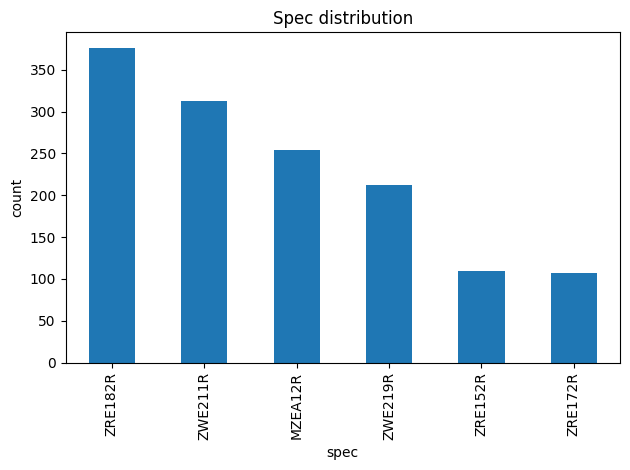

In [20]:
df_filt['spec'].value_counts().plot(kind='bar')
plt.title('Spec distribution')
plt.ylabel('count')
plt.tight_layout()
plt.show()

In [21]:
df_filt['badge'].value_counts()

badge
ascent sport           424
ascent sport hybrid    377
ascent                 280
zr hybrid               82
zr                      76
sx                      67
sx hybrid               66
Name: count, dtype: int64

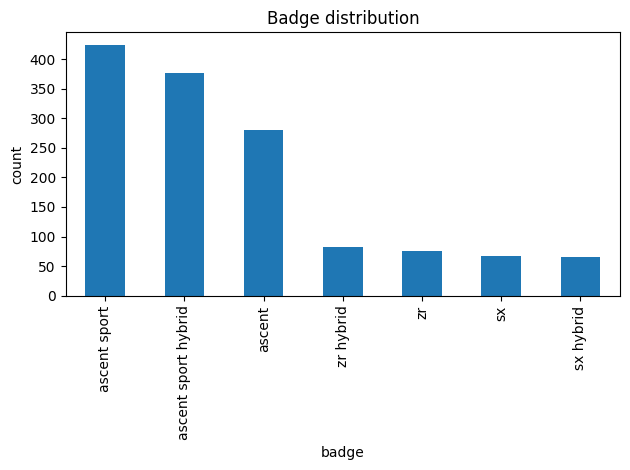

In [22]:
df_filt['badge'].value_counts().plot(kind='bar')
plt.title('Badge distribution')
plt.ylabel('count')
plt.tight_layout()
plt.show()

In [23]:
df_filt.head()

,badge,spec,body_style,kms,price,price_egc,seller_type,state,year,price_type
0,ascent,ZRE152R,hatch,182949,10990,"$10,499 Excl. Est. Govt. Charges",dealer,vic,2010,dap
1,ascent,ZRE152R,hatch,123000,10900,Excl. Govt. Charges,private,nsw,2010,egc
2,ascent,ZRE152R,hatch,100985,11000,Excl. Govt. Charges,private,nsw,2010,egc
3,ascent,ZRE152R,sedan,194676,9999,"$9,550 Excl. Est. Govt. Charges",dealer,vic,2010,dap
4,ascent,ZRE152R,hatch,185175,10200,Excl. Govt. Charges,private,wa,2010,egc


In [24]:
df_filt['body_style'].value_counts()

body_style
hatch    973
sedan    399
Name: count, dtype: int64

In [25]:
df_filt['kms'].describe()

count      1372.000000
mean      84390.347668
std       57867.367090
min           0.000000
25%       41854.250000
50%       72226.000000
75%      115125.000000
max      476804.000000
Name: kms, dtype: float64

In [26]:
bin_width = 50000
max_km = df_filt['kms'].max()
bins = range(0, int(max_km) + bin_width, bin_width)
km_blocks = pd.cut(df_filt['kms'], bins=bins, right=False)
block_counts = km_blocks.value_counts().sort_index()
block_counts

kms
[0, 50000)          414
[50000, 100000)     512
[100000, 150000)    258
[150000, 200000)    129
[200000, 250000)     43
[250000, 300000)     12
[300000, 350000)      2
[350000, 400000)      1
[400000, 450000)      0
[450000, 500000)      1
Name: count, dtype: int64

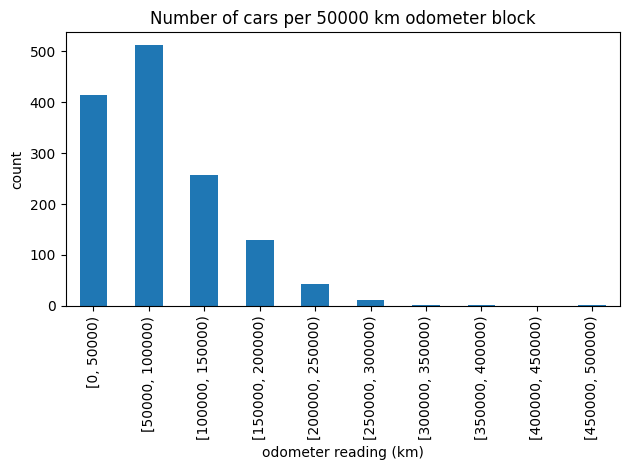

In [27]:
block_counts.plot(kind='bar')
plt.xlabel('odometer reading (km)')
plt.ylabel('count')
plt.title('Number of cars per 50000 km odometer block')
plt.xticks()
plt.tight_layout()
plt.show()


In [28]:
df_filt['price_type'].value_counts()

price_type
egc              1075
dap               288
indicativedap       9
Name: count, dtype: int64

In [29]:
filt = df_filt['price_type'] == 'indicativedap'
df_filt.loc[filt, 'price_type'] = 'dap'

In [30]:
df_filt['price_type'].value_counts()

price_type
egc    1075
dap     297
Name: count, dtype: int64

In [31]:
df_filt.head()

,badge,spec,body_style,kms,price,price_egc,seller_type,state,year,price_type
0,ascent,ZRE152R,hatch,182949,10990,"$10,499 Excl. Est. Govt. Charges",dealer,vic,2010,dap
1,ascent,ZRE152R,hatch,123000,10900,Excl. Govt. Charges,private,nsw,2010,egc
2,ascent,ZRE152R,hatch,100985,11000,Excl. Govt. Charges,private,nsw,2010,egc
3,ascent,ZRE152R,sedan,194676,9999,"$9,550 Excl. Est. Govt. Charges",dealer,vic,2010,dap
4,ascent,ZRE152R,hatch,185175,10200,Excl. Govt. Charges,private,wa,2010,egc


In [32]:
df_filt['price_egc'] = (
    df_filt['price_egc']
        .astype(str)
        .str.replace(r'\D', '', regex=True)      
        .replace('', np.nan)
        .astype('float64')  
)       

In [33]:
df_filt.head()

,badge,spec,body_style,kms,price,price_egc,seller_type,state,year,price_type
0,ascent,ZRE152R,hatch,182949,10990,10499.0,dealer,vic,2010,dap
1,ascent,ZRE152R,hatch,123000,10900,NaN,private,nsw,2010,egc
2,ascent,ZRE152R,hatch,100985,11000,NaN,private,nsw,2010,egc
3,ascent,ZRE152R,sedan,194676,9999,9550.0,dealer,vic,2010,dap
4,ascent,ZRE152R,hatch,185175,10200,NaN,private,wa,2010,egc


In [34]:
df_filt['price_egc'] = df_filt['price_egc'].fillna(df_filt['price'])

In [35]:
df_filt.head()

,badge,spec,body_style,kms,price,price_egc,seller_type,state,year,price_type
0,ascent,ZRE152R,hatch,182949,10990,10499.0,dealer,vic,2010,dap
1,ascent,ZRE152R,hatch,123000,10900,10900.0,private,nsw,2010,egc
2,ascent,ZRE152R,hatch,100985,11000,11000.0,private,nsw,2010,egc
3,ascent,ZRE152R,sedan,194676,9999,9550.0,dealer,vic,2010,dap
4,ascent,ZRE152R,hatch,185175,10200,10200.0,private,wa,2010,egc


In [36]:
df_filt.drop(columns=['price', 'price_type'], inplace=True)

In [37]:
df_filt.head()

,badge,spec,body_style,kms,price_egc,seller_type,state,year
0,ascent,ZRE152R,hatch,182949,10499.0,dealer,vic,2010
1,ascent,ZRE152R,hatch,123000,10900.0,private,nsw,2010
2,ascent,ZRE152R,hatch,100985,11000.0,private,nsw,2010
3,ascent,ZRE152R,sedan,194676,9550.0,dealer,vic,2010
4,ascent,ZRE152R,hatch,185175,10200.0,private,wa,2010


In [38]:
df_filt['price_egc'].describe()

count     1372.000000
mean     23357.966472
std       7485.400935
min       5000.000000
25%      17500.000000
50%      23888.000000
75%      28636.500000
max      48888.000000
Name: price_egc, dtype: float64

In [39]:
df_filt['seller_type'].value_counts()

seller_type
dealer      809
private     554
showroom      9
Name: count, dtype: int64

In [40]:
df_filt['seller_type'] = df_filt['seller_type'].replace({
    'showroom': 'dealer',})

In [41]:
df_filt['seller_type'].value_counts()

seller_type
dealer     818
private    554
Name: count, dtype: int64

In [42]:
df_filt['state'].value_counts()

state
nsw              434
vic              351
qld              260
wa               169
sa               106
act               19
tas               18
darling downs      9
nt                 6
Name: count, dtype: int64

In [43]:
df_filt['state'] = df_filt['state'].replace({
    'nsw': 'NSW',
    'vic': 'VIC',
    'qld': 'QLD',
    'sa': 'SA',
    'wa': 'WA',
    'act': 'ACT',
    'nt': 'NT',
    'tas': 'TAS',
    'darling downs': 'QLD'
})

In [44]:
df_filt['state'].value_counts()

state
NSW    434
VIC    351
QLD    269
WA     169
SA     106
ACT     19
TAS     18
NT       6
Name: count, dtype: int64

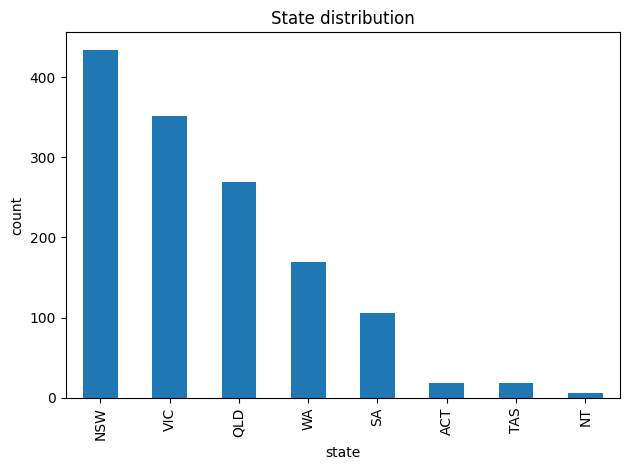

In [45]:
df_filt['state'].value_counts().plot(kind='bar')
plt.title('State distribution')
plt.ylabel('count')
plt.tight_layout()
plt.show()

In [46]:
df_filt['year'].value_counts()

year
2018    150
2019    143
2020    127
2021    111
2023    106
2022    104
2024    103
2017     92
2016     85
2014     75
2015     70
2013     64
2012     39
2010     35
2025     35
2011     33
Name: count, dtype: int64

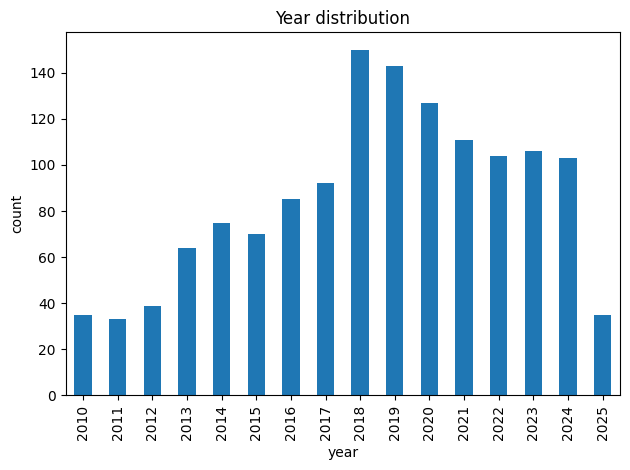

In [47]:
df_filt['year'].value_counts().sort_index().plot(kind='bar')
plt.title('Year distribution')
plt.ylabel('count')
plt.tight_layout()
plt.show()

In [48]:
df_filt.head()

,badge,spec,body_style,kms,price_egc,seller_type,state,year
0,ascent,ZRE152R,hatch,182949,10499.0,dealer,VIC,2010
1,ascent,ZRE152R,hatch,123000,10900.0,private,NSW,2010
2,ascent,ZRE152R,hatch,100985,11000.0,private,NSW,2010
3,ascent,ZRE152R,sedan,194676,9550.0,dealer,VIC,2010
4,ascent,ZRE152R,hatch,185175,10200.0,private,WA,2010


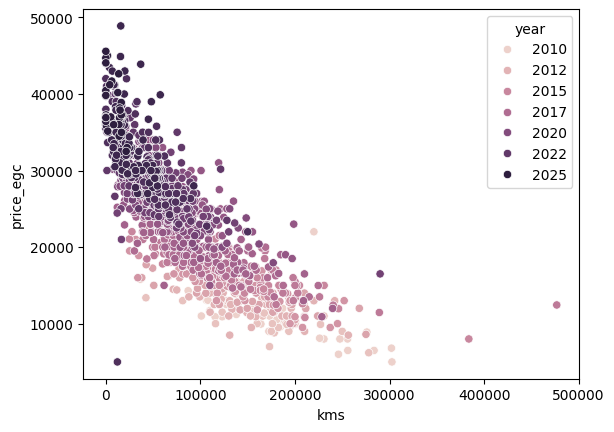

In [49]:
sns.scatterplot(data=df_filt, x='kms', y='price_egc', hue='year')
plt.show()

In [50]:
def get_iqr_outliers(df, col, ascending=False):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    outliers = df[(df[col] < lower) | (df[col] > upper)]
    outliers = outliers.sort_values(by=col, ascending=ascending)
    print(f"{col}: {outliers.shape[0]} outliers found")

    return outliers

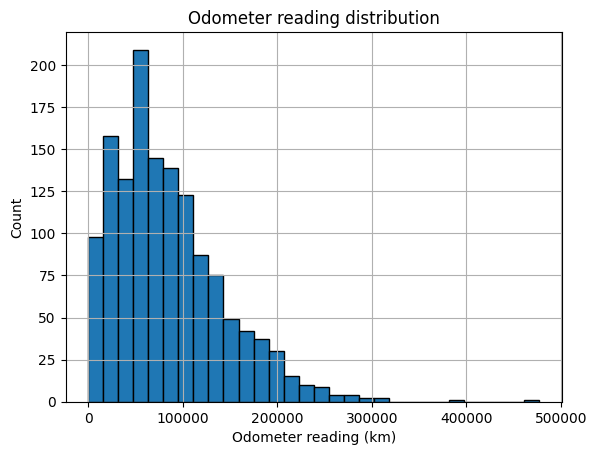

In [51]:
df_filt['kms'].hist(bins=30, edgecolor='black')
plt.title('Odometer reading distribution')
plt.xlabel('Odometer reading (km)')
plt.ylabel('Count')
plt.show()

In [52]:
df_filt['kms'].skew()

np.float64(1.1584719914573536)

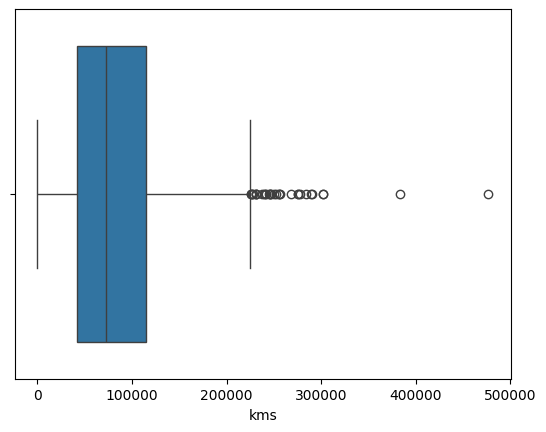

In [53]:
sns.boxplot(x=df_filt['kms'])
plt.show()

In [54]:
outliers_kms = get_iqr_outliers(df_filt, 'kms')
outliers_kms

kms: 31 outliers found


,badge,spec,body_style,kms,price_egc,seller_type,state,year
344,ascent,ZRE182R,hatch,476804,12440.0,private,ACT,2016
307,ascent,ZRE182R,hatch,383845,8000.0,private,VIC,2015
33,ascent,ZRE152R,sedan,302519,5000.0,private,NSW,2010
20,ascent sport,ZRE152R,hatch,302000,6800.0,private,SA,2010
1013,ascent sport,MZEA12R,sedan,290000,16500.0,private,NSW,2021
367,ascent sport,ZRE182R,hatch,289195,11457.0,dealer,VIC,2016
6,ascent,ZRE152R,sedan,283624,6500.0,private,ACT,2010
49,ascent,ZRE152R,hatch,278000,6200.0,private,WA,2011
30,ascent,ZRE152R,sedan,276000,8900.0,private,VIC,2010
140,ascent,ZRE152R,sedan,275062,8600.0,private,VIC,2013


In [55]:
df_filt.drop(outliers_kms.index[:2], inplace=True)

In [56]:
df_filt.nlargest(20, 'kms')

,badge,spec,body_style,kms,price_egc,seller_type,state,year
33,ascent,ZRE152R,sedan,302519,5000.0,private,NSW,2010
20,ascent sport,ZRE152R,hatch,302000,6800.0,private,SA,2010
1013,ascent sport,MZEA12R,sedan,290000,16500.0,private,NSW,2021
367,ascent sport,ZRE182R,hatch,289195,11457.0,dealer,VIC,2016
6,ascent,ZRE152R,sedan,283624,6500.0,private,ACT,2010
49,ascent,ZRE152R,hatch,278000,6200.0,private,WA,2011
30,ascent,ZRE152R,sedan,276000,8900.0,private,VIC,2010
140,ascent,ZRE152R,sedan,275062,8600.0,private,VIC,2013
170,ascent sport,ZRE182R,hatch,268000,12000.0,private,VIC,2013
87,ascent,ZRE152R,hatch,256400,8500.0,private,QLD,2012


In [57]:
df_filt.drop(index=1013, inplace=True)

In [58]:
df_filt.nsmallest(20, 'kms')

,badge,spec,body_style,kms,price_egc,seller_type,state,year
1347,sx hybrid,ZWE219R,hatch,0,40448.0,dealer,QLD,2025
1351,ascent sport hybrid,ZWE219R,hatch,0,36416.0,dealer,QLD,2025
1356,zr hybrid,ZWE219R,hatch,0,44707.0,dealer,QLD,2025
1357,zr hybrid,ZWE219R,hatch,0,45572.0,dealer,QLD,2025
1359,ascent sport hybrid,ZWE219R,hatch,0,37008.0,dealer,QLD,2025
1377,sx hybrid,ZWE219R,sedan,0,39732.0,dealer,QLD,2025
1382,ascent sport hybrid,ZWE219R,sedan,0,36908.0,dealer,QLD,2025
1389,sx hybrid,ZWE219R,hatch,0,39815.0,dealer,QLD,2025
1394,zr hybrid,ZWE219R,hatch,0,44066.0,dealer,QLD,2025
1346,sx hybrid,ZWE219R,hatch,9,44000.0,private,NSW,2025


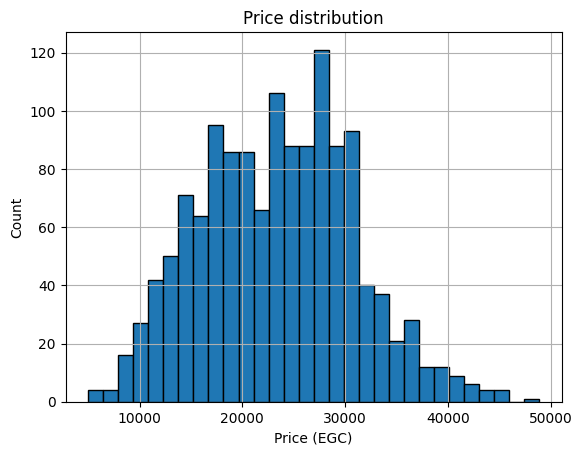

In [59]:
df_filt['price_egc'].hist(bins=30, edgecolor='black')
plt.title('Price distribution')
plt.xlabel('Price (EGC)')
plt.ylabel('Count')
plt.show()

In [60]:
df_filt['price_egc'].skew()

np.float64(0.1562775323008325)

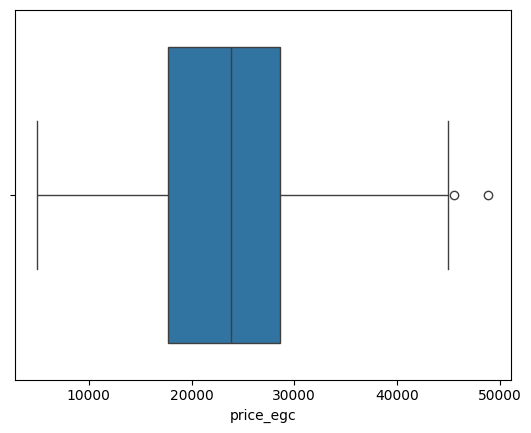

In [61]:
sns.boxplot(x=df_filt['price_egc'])
plt.show()

In [62]:
outliers_price_egc = get_iqr_outliers(df_filt, 'price_egc')
outliers_price_egc

price_egc: 2 outliers found


,badge,spec,body_style,kms,price_egc,seller_type,state,year
1275,zr hybrid,ZWE219R,hatch,15782,48888.0,dealer,NSW,2024
1357,zr hybrid,ZWE219R,hatch,0,45572.0,dealer,QLD,2025


In [63]:
df_filt.nlargest(20, 'price_egc')

,badge,spec,body_style,kms,price_egc,seller_type,state,year
1275,zr hybrid,ZWE219R,hatch,15782,48888.0,dealer,NSW,2024
1357,zr hybrid,ZWE219R,hatch,0,45572.0,dealer,QLD,2025
1354,zr hybrid,ZWE219R,hatch,1800,44990.0,private,QLD,2025
1258,zr hybrid,ZWE219R,hatch,15500,44888.0,dealer,NSW,2024
1356,zr hybrid,ZWE219R,hatch,0,44707.0,dealer,QLD,2025
1394,zr hybrid,ZWE219R,hatch,0,44066.0,dealer,QLD,2025
1346,sx hybrid,ZWE219R,hatch,9,44000.0,private,NSW,2025
1268,zr hybrid,ZWE219R,hatch,36871,43888.0,dealer,NSW,2024
1252,zr hybrid,ZWE219R,hatch,3838,43456.0,dealer,VIC,2024
1293,zr hybrid,ZWE219R,hatch,20077,42999.0,dealer,NSW,2024


In [64]:
df_filt.nsmallest(20, 'price_egc')

,badge,spec,body_style,kms,price_egc,seller_type,state,year
33,ascent,ZRE152R,sedan,302519,5000.0,private,NSW,2010
1227,sx hybrid,ZWE219R,sedan,12222,5000.0,private,VIC,2023
21,ascent,ZRE152R,sedan,246000,6000.0,private,WA,2010
49,ascent,ZRE152R,hatch,278000,6200.0,private,WA,2011
6,ascent,ZRE152R,sedan,283624,6500.0,private,ACT,2010
27,ascent,ZRE152R,hatch,255867,6500.0,private,QLD,2010
20,ascent sport,ZRE152R,hatch,302000,6800.0,private,SA,2010
55,ascent,ZRE152R,hatch,173099,7000.0,private,NSW,2011
19,ascent,ZRE152R,hatch,230646,7999.0,dealer,NSW,2010
32,ascent,ZRE152R,sedan,247501,7999.0,dealer,SA,2010


In [65]:
df_filt.drop(index=1227, inplace=True)

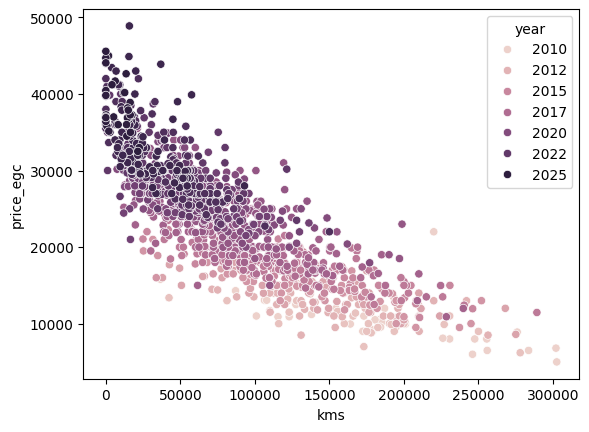

In [66]:
sns.scatterplot(data=df_filt, x='kms', y='price_egc', hue='year')
plt.show()

In [67]:
df_filt.groupby('year')['price_egc'].mean()

year
2010    10303.028571
2011    10968.363636
2012    12438.153846
2013    14627.640625
2014    15891.826667
2015    16924.130435
2016    18072.892857
2017    19318.271739
2018    21653.960000
2019    25128.720280
2020    26539.637795
2021    27201.290909
2022    29344.990385
2023    30619.057143
2024    32870.048544
2025    38561.228571
Name: price_egc, dtype: float64

In [68]:
filt = df_filt.groupby('year')['price_egc'].transform(zscore).abs() > 3
df_filt.loc[filt, :]

,badge,spec,body_style,kms,price_egc,seller_type,state,year
12,ascent,ZRE152R,sedan,220000,22000.0,private,VIC,2010
409,zr,ZRE172R,sedan,33202,27999.0,dealer,NSW,2017
602,ascent,ZRE172R,sedan,228450,10900.0,private,QLD,2018
765,ascent sport,MZEA12R,hatch,110000,15000.0,private,QLD,2019
769,zr,MZEA12R,hatch,21100,35500.0,private,NSW,2019
1275,zr hybrid,ZWE219R,hatch,15782,48888.0,dealer,NSW,2024


In [69]:
df_filt.drop(df_filt.loc[filt, :].index, inplace=True)

In [70]:
df_filt.groupby('year')['kms'].mean()

year
2010    182541.000000
2011    168081.121212
2012    149800.692308
2013    136654.890625
2014    125600.093333
2015    129267.101449
2016    116591.047619
2017    102463.593407
2018     88512.865772
2019     75516.921986
2020     61298.062992
2021     54113.900000
2022     46648.298077
2023     45669.266667
2024     26259.549020
2025      8423.228571
Name: kms, dtype: float64

In [71]:
filt = df_filt.groupby('year')['kms'].transform(zscore).abs() > 3
df_filt.loc[filt, :]

,badge,spec,body_style,kms,price_egc,seller_type,state,year
367,ascent sport,ZRE182R,hatch,289195,11457.0,dealer,VIC,2016
437,ascent sport,ZRE182R,hatch,224608,14980.0,dealer,NSW,2017
640,ascent,ZRE172R,sedan,239820,11990.0,private,NSW,2018
739,ascent,ZRE172R,sedan,190000,19000.0,private,VIC,2019
743,sx hybrid,ZWE211R,hatch,197000,18500.0,private,WA,2019
783,ascent sport hybrid,ZWE211R,hatch,198700,22999.0,private,NSW,2019
894,sx hybrid,ZWE211R,sedan,177000,17950.0,private,QLD,2020
904,ascent sport hybrid,ZWE211R,sedan,162000,20400.0,private,VIC,2020
1128,ascent sport hybrid,ZWE211R,sedan,128000,23500.0,private,QLD,2022
1233,ascent sport hybrid,ZWE219R,sedan,150000,22000.0,private,NSW,2023


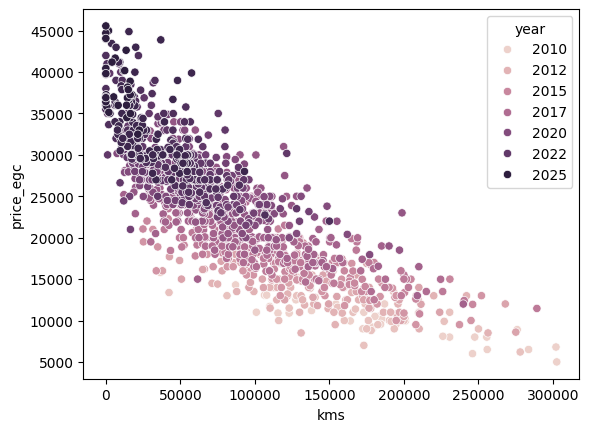

In [72]:
sns.scatterplot(data=df_filt, x='kms', y='price_egc', hue='year')
plt.show()

In [73]:
df_filt.shape

(1362, 8)

In [74]:
df_filt.head()

,badge,spec,body_style,kms,price_egc,seller_type,state,year
0,ascent,ZRE152R,hatch,182949,10499.0,dealer,VIC,2010
1,ascent,ZRE152R,hatch,123000,10900.0,private,NSW,2010
2,ascent,ZRE152R,hatch,100985,11000.0,private,NSW,2010
3,ascent,ZRE152R,sedan,194676,9550.0,dealer,VIC,2010
4,ascent,ZRE152R,hatch,185175,10200.0,private,WA,2010


In [75]:
df_filt[['kms', 'price_egc', 'year']].corr(method='spearman')

,kms,price_egc,year
kms,1.000000,-0.855972,-0.750892
price_egc,-0.855972,1.000000,0.909074
year,-0.750892,0.909074,1.000000


<Axes: >

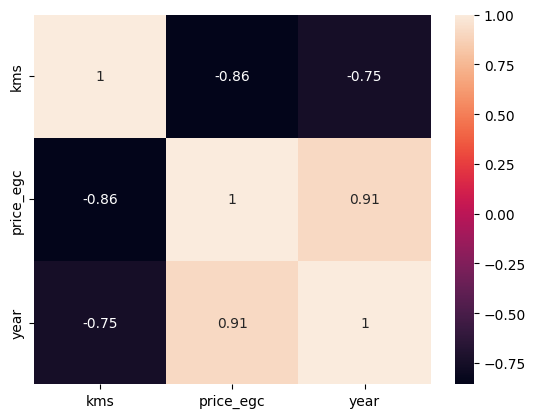

In [76]:
sns.heatmap(df_filt[['kms','price_egc','year']].corr(method='spearman'), annot=True)

In [77]:
X = df_filt.drop(columns=['price_egc'])
y = df_filt['price_egc']

In [78]:
X.head()

,badge,spec,body_style,kms,seller_type,state,year
0,ascent,ZRE152R,hatch,182949,dealer,VIC,2010
1,ascent,ZRE152R,hatch,123000,private,NSW,2010
2,ascent,ZRE152R,hatch,100985,private,NSW,2010
3,ascent,ZRE152R,sedan,194676,dealer,VIC,2010
4,ascent,ZRE152R,hatch,185175,private,WA,2010


In [79]:
y.head()

0    10499.0
1    10900.0
2    11000.0
3     9550.0
4    10200.0
Name: price_egc, dtype: float64

In [80]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

In [81]:
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [82]:
print(f'Training set size: {X_train.shape[0]} samples')
print(f'Validation set size: {X_val.shape[0]} samples')
print(f'Test set size: {X_test.shape[0]} samples')

Training set size: 953 samples
Validation set size: 204 samples
Test set size: 205 samples


In [83]:
numerical_features = ['kms', 'year']
categorical_features = ['badge', 'spec', 'body_style', 'seller_type', 'state']

In [84]:
preprocess1 = ColumnTransformer(
    transformers=[
        ('num1', RobustScaler(), numerical_features),
        ('cat1', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

In [85]:
linreg_pipe = Pipeline([
    ('preprocess', preprocess1),
    ('linreg', LinearRegression())
])
linreg_pipe.fit(X_train, y_train)

,steps,"[('preprocess', ...), ('linreg', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num1', ...), ('cat1', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [86]:
linreg_train_pred = linreg_pipe.predict(X_train)
linreg_val_pred = linreg_pipe.predict(X_val)

linreg_train_rmse = np.sqrt(mean_squared_error(y_train, linreg_train_pred))
print("Linear Regression Training RMSE:", linreg_train_rmse)

linreg_val_rmse = np.sqrt(mean_squared_error(y_val, linreg_val_pred))
print("Linear Regression Validation RMSE:", linreg_val_rmse)

linreg_train_mae = mean_absolute_error(y_train, linreg_train_pred)
print("Linear Regression Training MAE:", linreg_train_mae)

linreg_val_mae = mean_absolute_error(y_val, linreg_val_pred)
print("Linear Regression Validation MAE:", linreg_val_mae)

Linear Regression Training RMSE: 1926.1917544548412
Linear Regression Validation RMSE: 1776.5640915375338
Linear Regression Training MAE: 1431.5461933419597
Linear Regression Validation MAE: 1385.2519777049963


In [87]:
best_polyreg_pipe = None
best_val_mae = float('inf')

for d in range(2, 7):
    preprocess2 = ColumnTransformer(
    transformers=[
        ('num2',
         Pipeline([
             ('scaler2', RobustScaler()),
             ('poly2', PolynomialFeatures(degree=d, include_bias=False))
         ]),
         numerical_features
        ),
        ('cat2', OneHotEncoder(handle_unknown='ignore'), categorical_features)
                ]
    )

    polyreg_pipe = Pipeline([
    ('preprocess2', preprocess2),
    ('linreg', LinearRegression())
    ])

    polyreg_pipe.fit(X_train, y_train)

    polyreg_train_pred = polyreg_pipe.predict(X_train)
    polyreg_val_pred = polyreg_pipe.predict(X_val)

    polyreg_train_rmse = np.sqrt(mean_squared_error(y_train, polyreg_train_pred))
    print(f"Polynomial Regression (degree={d}) Training RMSE: {polyreg_train_rmse:.2f}")

    polyreg_val_rmse = np.sqrt(mean_squared_error(y_val, polyreg_val_pred))
    print(f"Polynomial Regression (degree={d}) Validation RMSE: {polyreg_val_rmse:.2f}")

    polyreg_train_mae = mean_absolute_error(y_train, polyreg_train_pred)
    print(f"Polynomial Regression (degree={d}) Training MAE: {polyreg_train_mae:.2f}")

    polyreg_val_mae = mean_absolute_error(y_val, polyreg_val_pred)
    print(f"Polynomial Regression (degree={d}) Validation MAE: {polyreg_val_mae:.2f}")

    print()

    if polyreg_val_mae < best_val_mae:
        best_val_mae = polyreg_val_mae
        best_polyreg_pipe = polyreg_pipe
        degree_best = d

Polynomial Regression (degree=2) Training RMSE: 1778.52
Polynomial Regression (degree=2) Validation RMSE: 1706.88
Polynomial Regression (degree=2) Training MAE: 1306.69
Polynomial Regression (degree=2) Validation MAE: 1302.39

Polynomial Regression (degree=3) Training RMSE: 1741.54
Polynomial Regression (degree=3) Validation RMSE: 1706.91
Polynomial Regression (degree=3) Training MAE: 1277.30
Polynomial Regression (degree=3) Validation MAE: 1304.35

Polynomial Regression (degree=4) Training RMSE: 1720.54
Polynomial Regression (degree=4) Validation RMSE: 1713.69
Polynomial Regression (degree=4) Training MAE: 1261.22
Polynomial Regression (degree=4) Validation MAE: 1299.78

Polynomial Regression (degree=5) Training RMSE: 1709.03
Polynomial Regression (degree=5) Validation RMSE: 1733.52
Polynomial Regression (degree=5) Training MAE: 1252.17
Polynomial Regression (degree=5) Validation MAE: 1317.76

Polynomial Regression (degree=6) Training RMSE: 1699.15
Polynomial Regression (degree=6) Val

In [88]:
preprocess3 = ColumnTransformer(
transformers=[
    ('num3', 'passthrough', numerical_features),  
    ('cat3', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

In [89]:
rf_pipe = Pipeline([
    ('preprocess3', preprocess3),
    ('rf', RandomForestRegressor(
        random_state=42,
        n_jobs=-1
    ))
])

In [90]:
param_distributions_rf = {
    'rf__n_estimators': stats.randint(100, 1000),
    'rf__max_depth': stats.randint(5, 20),
    'rf__max_features': stats.uniform(0.3, 0.6),
    'rf__min_samples_split': stats.randint(2, 10),
    'rf__min_samples_leaf': stats.randint(1, 10),
    'rf__max_samples': stats.uniform(0.3, 0.7)
}

In [91]:
rand_rf = RandomizedSearchCV(
    estimator = rf_pipe,
    param_distributions=param_distributions_rf,
    n_iter=50,
    scoring='neg_mean_absolute_error',   
    cv=5,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

rand_rf.fit(X_train, y_train)
print("Best Hyperparameters:", rand_rf.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Hyperparameters: {'rf__max_depth': 14, 'rf__max_features': np.float64(0.373252772820404), 'rf__max_samples': np.float64(0.5494084866538824), 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 476}


In [92]:
tuned_rf = rand_rf.best_estimator_
rf_train_pred = tuned_rf.predict(X_train)
rf_val_pred   = tuned_rf.predict(X_val)

rf_train_rmse = np.sqrt(mean_squared_error(y_train, rf_train_pred))
print("Random Forest Training RMSE:", rf_train_rmse)

rf_val_rmse   = np.sqrt(mean_squared_error(y_val, rf_val_pred))
print("Random Forest Validation RMSE:", rf_val_rmse)

rf_train_mae = mean_absolute_error(y_train, rf_train_pred)
print("Random Forest Training MAE:", rf_train_mae)

rf_val_mae = mean_absolute_error(y_val, rf_val_pred)
print("Random Forest Validation MAE:", rf_val_mae)

Random Forest Training RMSE: 1058.864897747497
Random Forest Validation RMSE: 1698.2539658781304
Random Forest Training MAE: 778.5186120591623
Random Forest Validation MAE: 1296.4386396453037


In [93]:
preprocess4 = ColumnTransformer(
    transformers=[
        ('num4', 'passthrough', numerical_features),
        ('cat4', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

In [94]:
xgb_pipe = Pipeline([
    ('preprocess4', preprocess4),
    ('xgb', XGBRegressor(
        n_estimators=3900,
        random_state=42,
        n_jobs=-1
    ))
])

In [95]:
param_distributions_xgb = {
    'xgb__learning_rate': stats.loguniform(0.01, 0.1),
    'xgb__max_depth': stats.randint(3, 6),   
    'xgb__min_child_weight': stats.loguniform(1.0, 10.0),
    'xgb__subsample': stats.uniform(0.6, 0.3),  
    'xgb__colsample_bytree': stats.uniform(0.6, 0.3),  
    'xgb__reg_lambda': stats.loguniform(0.1, 10.0),
    'xgb__gamma': stats.loguniform(0.0 + 1e-3, 1.0),
}

In [96]:
rand_xgb = RandomizedSearchCV(
    estimator = xgb_pipe,
    param_distributions=param_distributions_xgb,
    n_iter=50,
    scoring='neg_mean_absolute_error',
    cv=5,
    verbose=1,
    n_jobs=-1,
    random_state=42
)
rand_xgb.fit(X_train, y_train)
print("Best Hyperparameters:", rand_xgb.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Hyperparameters: {'xgb__colsample_bytree': np.float64(0.6888820517112247), 'xgb__gamma': np.float64(0.0031318490181411187), 'xgb__learning_rate': np.float64(0.010366601559510755), 'xgb__max_depth': 3, 'xgb__min_child_weight': np.float64(5.918951335463645), 'xgb__reg_lambda': np.float64(0.24970737145052724), 'xgb__subsample': np.float64(0.6016566351370807)}


In [97]:
tuned_xgb = rand_xgb.best_estimator_
xgb_train_pred = tuned_xgb.predict(X_train)
xgb_val_pred   = tuned_xgb.predict(X_val)

xgb_train_rmse = np.sqrt(mean_squared_error(y_train, xgb_train_pred))
print("XGBoost Training RMSE:", xgb_train_rmse)

xgb_val_rmse = np.sqrt(mean_squared_error(y_val, xgb_val_pred))
print("XGBoost Validation RMSE:", xgb_val_rmse)

xgb_train_mae = mean_absolute_error(y_train, xgb_train_pred)
print("XGBoost Training MAE:", xgb_train_mae)

xgb_val_mae = mean_absolute_error(y_val, xgb_val_pred)
print("XGBoost Validation MAE:", xgb_val_mae)

XGBoost Training RMSE: 1161.093887033843
XGBoost Validation RMSE: 1683.7443490871963
XGBoost Training MAE: 894.5470794325486
XGBoost Validation MAE: 1292.1713460286458


In [98]:
polyreg_test_pred = best_polyreg_pipe.predict(X_test)
polyreg_test_mae = mean_absolute_error(y_test, polyreg_test_pred)
print("Best Polynomial Regression (degree={}) Test MAE: {}".format(degree_best, polyreg_test_mae))

rf_test_pred = tuned_rf.predict(X_test)
rf_test_mae = mean_absolute_error(y_test, rf_test_pred)
print("Random Forest Test MAE:", rf_test_mae)   

xgb_test_pred = tuned_xgb.predict(X_test)
xgb_test_mae = mean_absolute_error(y_test, xgb_test_pred)
print("XGBoost Test MAE:", xgb_test_mae)

Best Polynomial Regression (degree=4) Test MAE: 1284.697667542747
Random Forest Test MAE: 1314.2981121529904
XGBoost Test MAE: 1263.9982469512195


In [99]:
val_pred = best_polyreg_pipe.predict(X_val)
residuals = y_val.values - val_pred

In [100]:
low_q, high_q = np.quantile(residuals, [0.15, 0.85])

print('Lower residual quantile:', low_q)
print('Upper residual quantile:', high_q)

Lower residual quantile: -1353.778660073855
Upper residual quantile: 1826.7344994605212


In [101]:
low_q_rounded = round(low_q, -2)
high_q_rounded = round(high_q, -2)
print('Rounded Lower residual quantile:', low_q_rounded)
print('Rounded Upper residual quantile:', high_q_rounded)

Rounded Lower residual quantile: -1400.0
Rounded Upper residual quantile: 1800.0


In [102]:
joblib.dump(best_polyreg_pipe, "price_model.joblib")
joblib.dump(
    {
        "low_q": low_q_rounded,
        "high_q": high_q_rounded
    },
    "price_range.joblib"
)

['price_range.joblib']

In [103]:
#testing
sample_X = X_val.iloc[[18]]
sample_y = y_val.iloc[18]

pred = best_polyreg_pipe.predict(sample_X)[0]
lo = pred + low_q_rounded
hi = pred + high_q_rounded

print("True value:", round(sample_y))
print("Predicted:", round(pred))
print("Range:", round(lo), "-", round(hi))

True value: 24500
Predicted: 25575
Range: 24175 - 27375


In [104]:
year_badge = (
    df_filt.groupby("year")["badge"]
    .unique()
    .apply(lambda x: sorted([str(v) for v in x]))
    .to_dict()
)

year_spec = (
    df_filt.groupby("year")["spec"]
    .unique()
    .apply(lambda x: sorted([str(v) for v in x]))
    .to_dict()
)

with open("year_badge.json", "w") as f:
    json.dump(year_badge, f)

with open("year_spec.json", "w") as f:
    json.dump(year_spec, f)